In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAthensV2

import pennylane as qml


In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import custom_ghz
from circuits.modify_circuits import append_pqc_to_quantum_circuit, append_inverse_to_quantum_circuit, get_circuit_for_model, get_unitary_for_model_pennylane
from circuits.pqc_circuits import simple_PQC_pennylane

from simulator.simulate import get_ideal_shots, run_circuit_sim, get_ideal_data


In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    device = torch.device("mps")
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    device = torch.device("cuda")
else:
    print('Torch running on CPU')
    device = torch.device("cpu")

Torch running on Apple GPU


In [5]:
NUM_SHOTS = 10**4
NUM_QUBITS = 5
INPUT_BITS = '10101'
EPOCHS = 5
# fakeVigo2_backend = FakeVigoV2()
fakeAthensV2_backend = FakeAthensV2()

ideal_sim = AerSimulator()
noisy_sim = AerSimulator().from_backend(fakeAthensV2_backend)

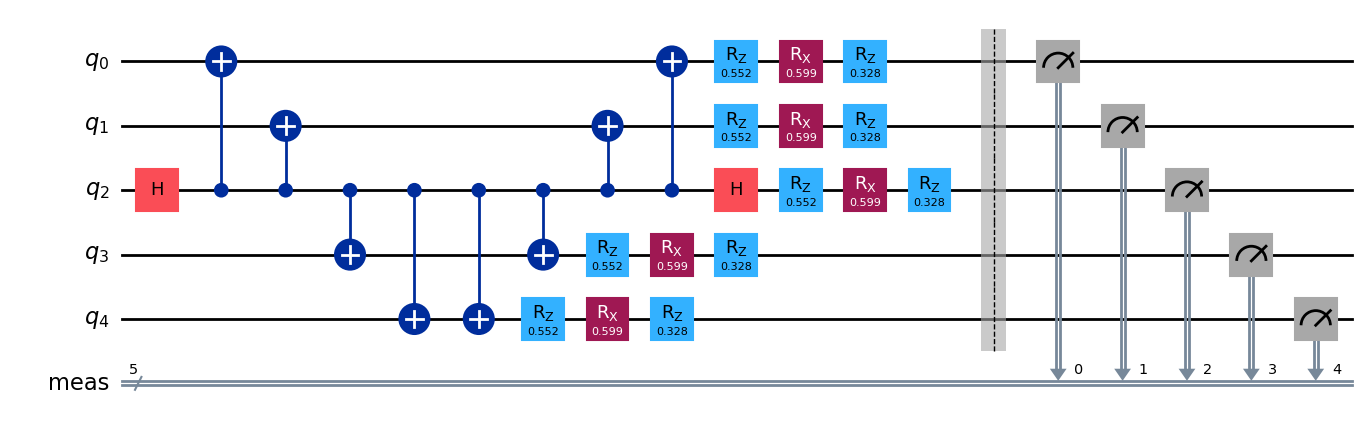

In [6]:
test_circ = append_inverse_to_quantum_circuit(custom_ghz(5, 2))
test_params = torch.rand(3)
# print(test_params)
# test_circ = test_circ.compose(test_circ.inverse())
test_circ_pqc = append_pqc_to_quantum_circuit(test_circ, test_params)
test_circ_pqc.draw('mpl')

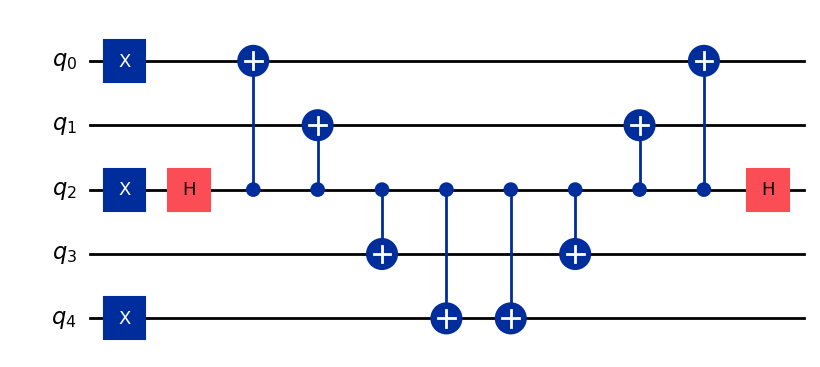

In [7]:
mcirc = get_circuit_for_model(INPUT_BITS, custom_ghz(5,2))
mcirc.draw('mpl')

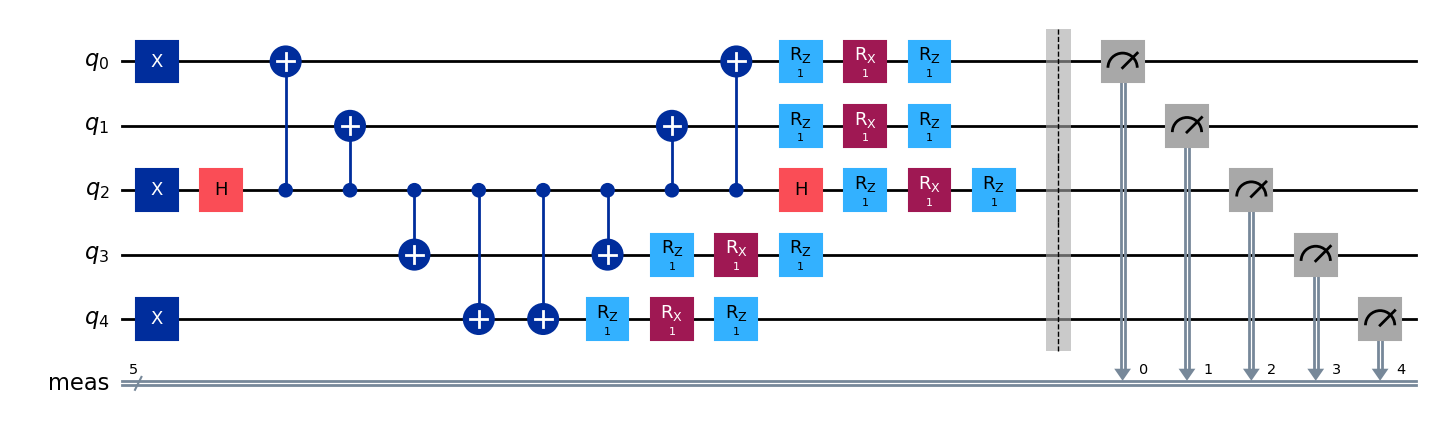

In [8]:
mcirc_pqc = append_pqc_to_quantum_circuit(mcirc, torch.ones(mcirc.num_qubits))
mcirc_pqc.draw('mpl')

In [9]:
ideal_counts = get_ideal_shots(input=INPUT_BITS, shots=NUM_SHOTS)
measured_counts = run_circuit_sim(circuit=mcirc_pqc, simulator=noisy_sim, num_shots=NUM_SHOTS)

print(ideal_counts)
print(measured_counts)

print(torch.dist(ideal_counts, measured_counts))

tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0., 10000.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.])
tensor([  69,  257,   30,   70,  268,  835,   67,  251,   34,   69,    8,   22,
         100,  251,   27,   94,  256,  807,   84,  221,  833, 2511,  242,  796,
          82,  237,   23,   84,  250,  785,   68,  269])
tensor(7750.6279)


In [10]:
ideal_data = get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=2500, prob_dist=True)
print(len(ideal_data[10]))

2


In [11]:
class SimpleCustomQuantumModel(nn.Module):
    def __init__(self, num_params:int, base_circuit: QuantumCircuit, simulator:AerSimulator=fakeAthensV2_backend, num_shots=NUM_SHOTS, circuit_runner = run_circuit_sim):
        super().__init__()

        self.pqc_params = nn.Parameter(torch.rand(num_params))
        self.simulator = simulator
        self.transpile = transpile
        self.num_shots = num_shots
        self.runner = circuit_runner
        self.base_circuit = base_circuit
        self.pennylane_dev = qml.device("default.qubit", wires=self.base_circuit.num_qubits)

        pass

    
    def forward(self, unitary:Operator):
        """
        @param circuit: The quantum circuit with the input and it's inverse appended. 
        """    
        # circuit = circuit.remove_final_measurements(inplace=False)
        # circuit_pqc = append_pqc_to_quantum_circuit(circuit, self.pqc_params)
        # measured_tensor = self.runner(circuit_pqc, self.simulator, self.num_shots)

        # return measured_tensor

        qnode = self.make_pennylane_qnode()
        probs = qnode(self.pqc_params, unitary, self.base_circuit.num_qubits)
        # shots_scaled = probs * self.num_shots

        return probs

    

    
    def make_pennylane_qnode(self):
        dev = qml.device("default.qubit", wires=self.base_circuit.num_qubits)

        @qml.qnode(dev, interface="torch", diff_method="backprop")
        def pennylane_pqc_circ(params, unitary, num_qubits):
            qml.QubitUnitary(unitary, wires=range(num_qubits))  # fixed input/inverse
            simple_PQC_pennylane(num_qubits=num_qubits, params=params)
            
            return qml.probs(wires=range(num_qubits))

        return pennylane_pqc_circ



        


In [12]:
ghz_circuit = custom_ghz(NUM_QUBITS, 2)
pqc_model = SimpleCustomQuantumModel(num_params=3, num_shots=NUM_SHOTS, base_circuit=ghz_circuit)

optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.00001)
loss_fn = nn.MSELoss()

print(device)

mps


In [13]:

for i in range(EPOCHS):
    print(f'Starting Epoch {i}')
    pqc_model.train()
    ctr = 0
    for bitstring, ideal in ideal_data:
        ctr += 1
        optimizer.zero_grad()

        # measured = pqc_model(get_circuit_for_model(bitstring, ghz_circuit))
        model_unitary = get_unitary_for_model_pennylane(bitstring, pqc_model.base_circuit)

        # print(len(measured), len(ideal))
        measured = pqc_model(model_unitary)

        ideal = ideal.float().to(device)
        measured = measured.float().to(device)
        
        loss = loss_fn(measured, ideal)

        loss.backward()
        optimizer.step()

        if (ctr) % (len(ideal_data) // 10) == 0:
            
            print(f'Count {ctr}, Loss: {loss:.4f}')
            # print(f'Count {ctr}, Loss: {loss.item():.4f}, bitstring: {bitstring}, ideal: {ideal}, measured: {measured}')


    

Starting Epoch 0
Count 250, Loss: 0.0385
Count 500, Loss: 0.0385
Count 750, Loss: 0.0384
Count 1000, Loss: 0.0097
Count 1250, Loss: 0.0391
Count 1500, Loss: 0.0383
Count 1750, Loss: 0.0098
Count 2000, Loss: 0.0390
Count 2250, Loss: 0.0390
Count 2500, Loss: 0.0382
Starting Epoch 1
Count 250, Loss: 0.0381
Count 500, Loss: 0.0381
Count 750, Loss: 0.0381
Count 1000, Loss: 0.0101
Count 1250, Loss: 0.0388
Count 1500, Loss: 0.0380
Count 1750, Loss: 0.0102
Count 2000, Loss: 0.0387
Count 2250, Loss: 0.0387
Count 2500, Loss: 0.0378
Starting Epoch 2
Count 250, Loss: 0.0378
Count 500, Loss: 0.0378
Count 750, Loss: 0.0377
Count 1000, Loss: 0.0105
Count 1250, Loss: 0.0385
Count 1500, Loss: 0.0376
Count 1750, Loss: 0.0106
Count 2000, Loss: 0.0384
Count 2250, Loss: 0.0384
Count 2500, Loss: 0.0375
Starting Epoch 3
Count 250, Loss: 0.0375
Count 500, Loss: 0.0375
Count 750, Loss: 0.0374
Count 1000, Loss: 0.0109
Count 1250, Loss: 0.0382
Count 1500, Loss: 0.0373
Count 1750, Loss: 0.0110
Count 2000, Loss: 0

In [14]:
pqc_model.pqc_params

Parameter containing:
tensor([0.7587, 0.3451, 0.7772], requires_grad=True)

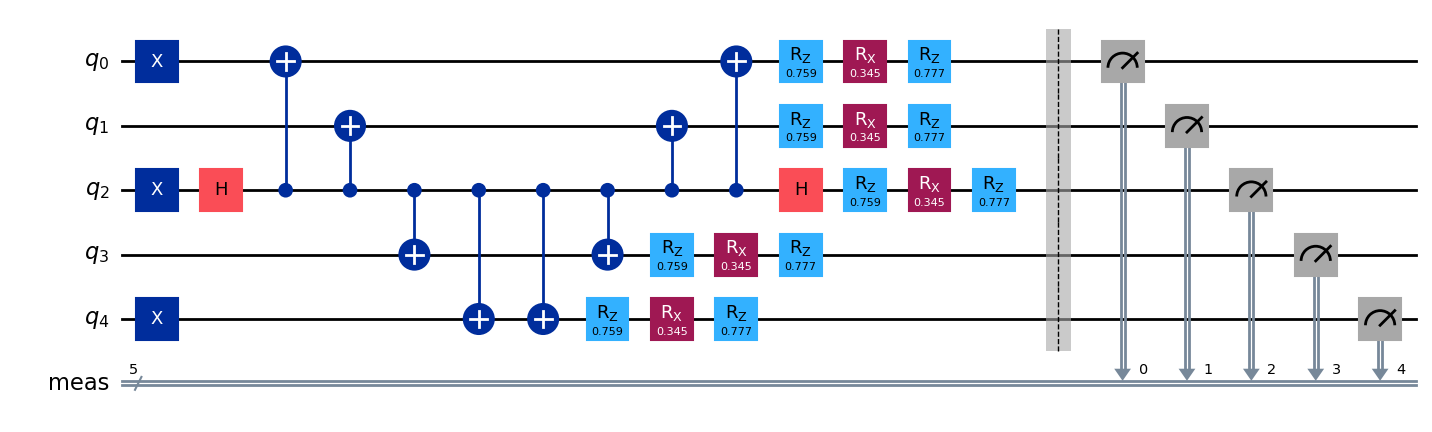

In [15]:
mcirc_post = append_pqc_to_quantum_circuit(mcirc, pqc_model.pqc_params)
mcirc_post.draw('mpl')

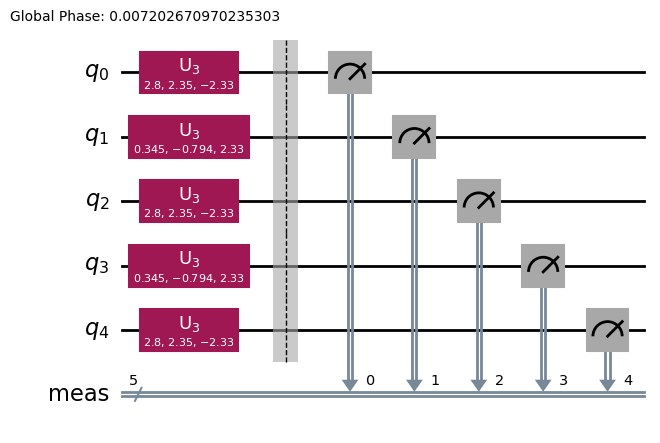

In [16]:
ideal_sim = AerSimulator()
transpiled_circ = transpile(mcirc_post, ideal_sim)
transpiled_circ.draw('mpl')

In [17]:
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

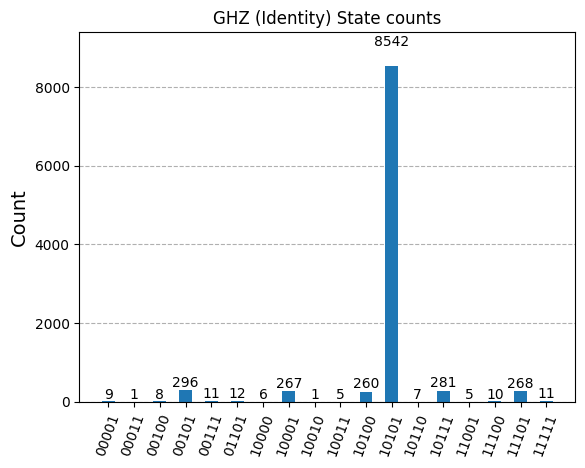

In [18]:
from qiskit.visualization import plot_histogram

plot_histogram(counts, title='GHZ (Identity) State counts')